# Proof of concept - online rhat

In [1]:
import blackjax
import jax
import chex
import jax.numpy as jnp
import arviz as az
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
from blackjax.diagnostics import potential_scale_reduction
import matplotlib.pyplot as plt
from typing import NamedTuple
from jax.tree_util import tree_map, tree_structure
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

ADT for the welford algorithm that tracks mean and variance for each chain variable of interest. This type will end up being the leaf of a pytree structured like the parameter.

In [2]:
class WelfordState(NamedTuple):
    K: chex.Array
    Ex: chex.Array
    Ex2: chex.Array
    n: chex.Array


def welford_init(K) -> WelfordState:
  """Initialize new welford algorithm state.
  
  Args:
    K: estimated mean value of data. Same shape as data.
  """
  return WelfordState(K=K*1., Ex=K*0., Ex2=K*0., n=K*0)

def welford_add(x: chex.Array, state: WelfordState) -> WelfordState:
  return WelfordState(K=state.K, Ex=state.Ex + x - state.K, Ex2=state.Ex2 + (x - state.K)**2, n=state.n + 1)

def welford_mean(state: WelfordState):
  return state.K + state.Ex / state.n

def welford_var(state: WelfordState):
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [3]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array
    post_id: chex.Array

In [4]:
class ExtendedState(NamedTuple):
    state: object
    rng_key: chex.Array
    pred_ws: WelfordState
    param_ws: WelfordState

In [5]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

In [7]:
num_samples = 200
warmup_iter = 500
num_chains = 3
seed = 123
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(seed), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key, pid):
  k1, k2 = jax.random.split(key)
  theta = Theta(
    beta=jax.random.normal(key=k1, shape=(p,)),
    sigsq=jax.random.normal(key=k2),
    post_id=1.0*pid)
  return theta

In [8]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logprob_fn, num_steps=warmup_iter, progress_bar=True)
final_warmup_state, kernel, info = warmup.run(warmup_key, make_initial_pos(init_key, 0))

Running window adaptation



CPU times: user 4.24 s, sys: 25 ms, total: 4.27 s
Wall time: 4.22 s


In [9]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs],
    post_id = 1.0*jnp.arange(num_chains)
)
initial_states = jax.vmap(lambda p: blackjax.nuts.init(p, logprob_fn))(initial_positions)

In [10]:
# sense check logprob_fn
[logprob_fn(final_warmup_state.position), jax.vmap(logprob_fn)(initial_positions)]

[Array(-196.40106, dtype=float32),
 Array([-192.4809 , -190.7263 , -194.34314, -193.96323, -191.08167,
        -193.45099, -190.05582, -191.68242, -195.66983, -194.12477],      dtype=float32)]

Seems pretty safe to sample from second half of warmup trace:

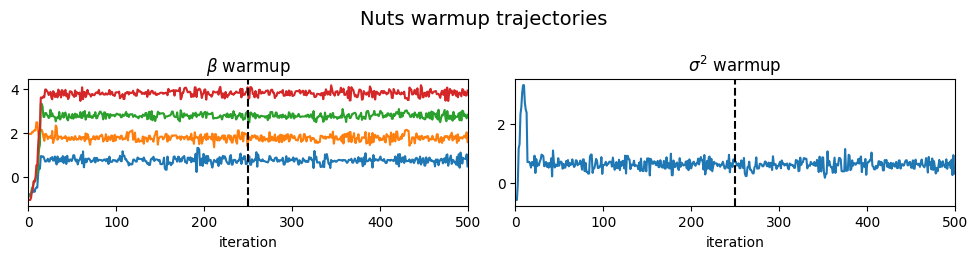

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,2.6))
bax, sax = axes
bax.plot(info[0].position.beta)
bax.set_title(r'$\beta$ warmup')
sax.plot(info[0].position.sigsq)
sax.set_title(r'$\sigma^2$ warmup')
for ax in axes:
    ax.set_xlabel('iteration')
    ax.axvline(warmup_iter//2, color='k', linestyle='--')
    ax.set_xlim(0, info[0].position.beta.shape[0])
fig.suptitle('Nuts warmup trajectories', fontsize=14)
fig.tight_layout()

Named tuple for holding MCMC results, split into 2 half-chains

In [12]:
# stack arrays in pytrees
def tree_stack(trees):
    return tree_map(lambda *xs: jnp.stack(xs, axis=0), *trees)

# stack arrays in pytrees
def tree_concat(trees):
    return tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *trees)

In [13]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def log_p(theta):
        e = X @ theta.beta - y
        return -0.5 * (
            jnp.log(2 * jnp.pi)
            + jnp.log(theta.sigsq)
            + jnp.dot(e, e)/theta.sigsq
        )
    def one_mcmc_step(extended_state, idx):
        i_key, carry_key = jax.random.split(extended_state.rng_key)
        chain_state, _ = kernel(i_key, extended_state.state)
        elpd_contrib = log_p(chain_state.position)
        carry_pred_ws = welford_add(elpd_contrib, extended_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, extended_state.param_ws)
        carry_state = ExtendedState(chain_state, carry_key, carry_pred_ws, carry_param_ws)
        return carry_state, chain_state  # we'll eventually drop chain state and return None instead
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_p(initial_state.position)),
        param_ws=tree_map(welford_init, initial_state.position))
    #carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    carry_state_1h, states_1h = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(num_samples//2))
    # second half of chain
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_p(carry_state_1h.state.position)),
        param_ws=tree_map(welford_init, carry_state_1h.state.position))
    #carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    carry_state_2h, states_2h = jax.lax.scan(one_mcmc_step, carry_state_1h, jnp.arange(num_samples//2, num_samples))
    return tree_stack((carry_state_1h, carry_state_2h,)), tree_concat((states_1h, states_2h,))

In [14]:
def to_arviz(theta):
    theta_dict = dict(zip(theta.position._fields, theta.position))
    return az.convert_to_inference_data(theta_dict)

In [15]:
# smoke test a single chain
# state, trace = inference_loop(sampling_key, kernel, final_warmup_state, num_samples)

In [16]:
%%time

sampling_keys = jax.random.split(sampling_key, num_chains)

state, trace = jax.vmap(inference_loop, in_axes=(0, None, 0, None))(sampling_keys, kernel, initial_states, num_samples)

CPU times: user 15.9 s, sys: 38.8 ms, total: 15.9 s
Wall time: 15.9 s


In [17]:
trace_az = to_arviz(trace)
az.summary(trace_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],7.610000e-01,1.460000e-01,4.850000e-01,1.033000e+00,2.000000e-03,2.000000e-03,4666.0,3708.0,1.00
beta[1],1.782000e+00,1.380000e-01,1.531000e+00,2.053000e+00,2.000000e-03,1.000000e-03,5847.0,3929.0,1.00
beta[2],2.785000e+00,1.250000e-01,2.560000e+00,3.022000e+00,2.000000e-03,1.000000e-03,4916.0,3851.0,1.00
beta[3],3.802000e+00,1.370000e-01,3.554000e+00,4.066000e+00,2.000000e-03,1.000000e-03,5570.0,3984.0,1.00
sigsq,6.430000e-01,1.430000e-01,3.740000e-01,9.090000e-01,2.000000e-03,1.000000e-03,6044.0,4095.0,1.00
post_id,3.185464e+12,1.042650e+14,-1.753245e+14,2.154268e+14,2.721705e+13,1.964135e+13,16.0,23.0,1.71


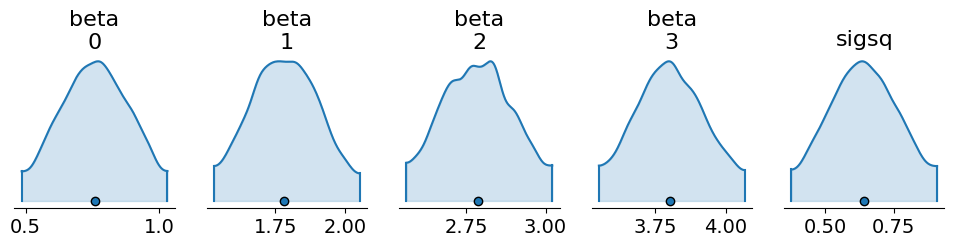

In [18]:
az.plot_density(trace_az, var_names=['beta', 'sigsq'], figsize=(12,2), shade=0.2, grid=(1,5))
fig.tight_layout()

In [19]:
tree_map(jnp.shape, trace.position)

Theta(beta=(10, 500, 4), sigsq=(10, 500), post_id=(10, 500))

In [20]:
tree_map(jnp.shape, state.state.position)

Theta(beta=(10, 2, 4), sigsq=(10, 2), post_id=(10, 2))

In [21]:
def split_rhat(means: chex.Array, vars: chex.Array, n: int) -> float:
    """Compute a single split Rhat from summary statistics of split chains.

    Args:
        means: means of split chains
        vars:  variances of split chains
        n:     number of draws per split chain (ie half draws in an original chain)
    """
    W = jnp.mean(vars)
    m = len(means)  # number of split chains
    B = n*jnp.var(means, ddof=1)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

def split_rhat_welford(ws: WelfordState) -> float:
    """Compute a single split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    """
    means = jax.vmap(welford_mean)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[0]
    return split_rhat(means, vars, n)

def split_rhat_state(welford_tree):
    """Compute split Rhat from welford states of split chains.
    
    Args:
        welford_tree: Pytree of Welford states for split chains
    """
    # first two axes are (chain #, half #), which we combine to a single dimension
    com_chains = tree_map(lambda x: jnp.reshape(x, (-1, *x.shape[2:])), welford_tree)
    rhats = tree_map(split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    return rhats

In [22]:
split_rhat_state(state.param_ws)

Theta(beta=Array([8.342368, 8.342368, 8.342368, 8.342368], dtype=float32), sigsq=Array(0.9985912, dtype=float32), post_id=Array(1.5284333, dtype=float32))

In [23]:
split_rhat_state(state.pred_ws)

Array(0.9988771, dtype=float32)

In [24]:
az.summary(trace_az).r_hat.to_numpy()

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.71])